In [3]:
import numpy as np
import matplotlib.pyplot as plt

# A New Approach for the Dynamics of Ultra-High-Frequency Data: The Model with Uncertainty Zones

This notebook attempts to reproduce the main findings and simulations of the paper from M. Mathieu Rosenbaum et M. Christian Y. Robert published in the Journal of Financial Econometrics, 2011, Vol. 9, No. 2, 344-366.

## Model

In our notebook we stick to the same notation as in the paper. For more details please refer to it.

Let $(X_{t})_{t \geq 0}$ be the efficient price of the asset. Let $(\Omega, (\mathcal{F}_{t})_{t\geq 0},\mathbb{P})$ be the filtered probability space, and $(W_{t})_{t\geq 0}$ a standard $\mathcal{F}$-Brownian motion. We assume that the logarithm of the price is $\mathcal{F}_{t}$-adapted continuous semi-martingale that follows the equation:

$$
Y_{t} = \log(X_{t}) = \log(X_{0}) + \int_{0}^{t} a_{u}dt + \int_{0}^{t}\sigma_{u-} dW_{u}
$$

We define the tick grid as $\{k\alpha, k\in\mathbb{N}\}$ with $\alpha$ the tick size. We now define the uncertainty zones in between the mid-points of the tick grid as $\mathcal{U}_{k} = [0,+\infty) \times (d_{k}, u_{k})$ with:

$$
d_{k} = \left(k + \frac{1}{2} - \eta\right)\alpha \quad\text{and}\quad u_{k} = \left(k+\frac{1}{2}+\eta\right) \alpha, \quad \text{with}\quad 0<\eta<1
$$

Let us now define the sequence of exit times form uncertainty zones $(\tau_{i})_{i\geq 0}$. We take $\tau_{0} = 0$ and we assume that we start at the tick $k_{0} = X_{0}^{(\alpha)} / \alpha$, $X_{0}^{(\alpha)}$ being $X_{0}$ rounded to the nearest multiple of $\alpha$. Let $\tau_{1}$ be the first exit time from the set $(d_{k_{0}-1}, u_{k_{0}})$.

We then define recursively $\tau_{i+1}$ as the exit time of $(X_t)_{t>\tau_i}$ of the uncertainty zone $(d_{k_i-L_i}, u_{k_i+L_i -1})$, where $k_i=X_{\tau_i}^{(\alpha)} / \alpha$ and $L_i$ representing the absolute value in number of ticks of the price jump between the $i^{th}$ and the $(i + 1)^{th}$ transaction leading to a price change.

$$
\tau_{i+1} = \inf\left\{t: t>\tau_i, \quad X_t = (k_i -L_i-\frac{1}{2}+\eta)\alpha \quad \text{or}\quad X_t = (k_i +L_i-\frac{1}{2}+\eta)\alpha\right\}
$$

We'll assume here that the price can only jump from one tick to one comeshutive tick ($L_i = 1$). We also assume that the transactions which lead to a change of price are exactly made at the times $\tau_i$. We call by $(P_{\tau_i})_{i\in\mathbb{N}}$ the prices of these transactions.



From this we can retrieve the efficient price at times $\tau_i$:

$$
X_{\tau_i} = P_{\tau_i} - sign(P_{\tau_i} - P_{\tau_{i-1}})\left(\frac{1}{2} - \eta\right)\alpha
$$

## Simulation

We take the simple model of the paper:

$$
dX_t = \sigma_tX_tdW_t, \quad X_0 = 100, \quad t\in[0, 100]
$$

where $(\sigma_t)_{t\in[0, 1]}$ is a deterministic function.
The interval $[0, 1]$ corresponds to one trading day of 8h.

In [23]:
# Parameters
alpha = 0.05
eta = 0.05
X0 = 100
mesh = 3600 * 8 * 10 
T = 1
dt = T / mesh
mu = 0

### Volatility studied

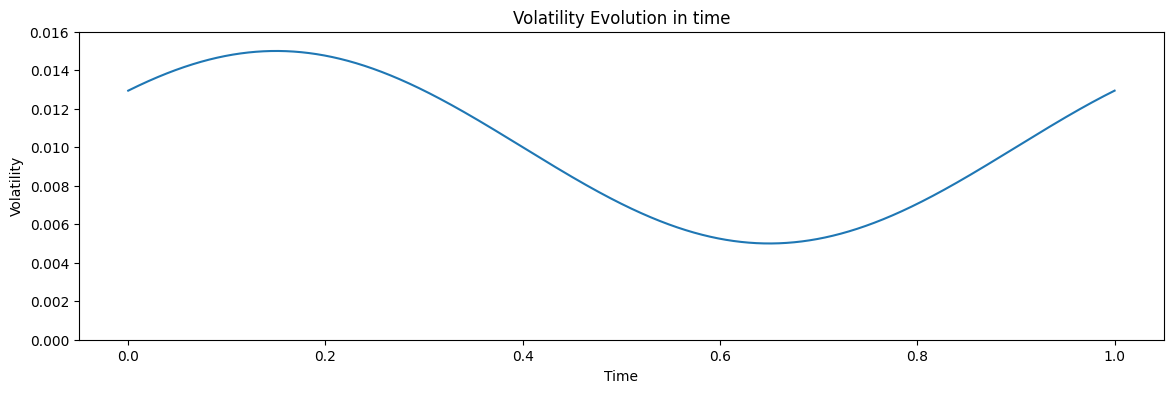

In [24]:
def estimated_real_volatility(x: np.ndarray) -> np.ndarray:
    return np.sin(2 * np.pi * (x + 0.1)) * 0.005 + 0.01

t = np.arange(0, T, dt)
plt.figure(figsize=(14, 4))
plt.plot(t, estimated_real_volatility(t))
plt.xlabel('Time')
plt.ylim(0,0.016)
plt.ylabel('Volatility')
plt.title('Volatility Evolution in time')
plt.show()

### Theoretical price variation

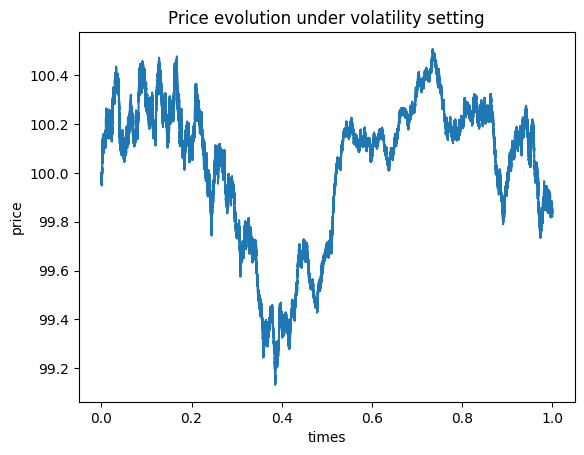

In [6]:
def price_euler(mu: float, sigma: np.ndarray, S0: float, dt:float, t: np.ndarray) -> np.ndarray:
    dW = np.random.normal(0, 1, mesh)
    S = np.zeros(dW.size)
    S[0] = S0

    for i in range(dW.size - 1):
        dS = mu * dt + sigma[i] * dW[i] * np.sqrt(dt) 
        S[i+1] = S[i] * np.exp(dS)
        
    return S


S0 = X0
sigma = estimated_real_volatility(t)
plt.plot(t, price_euler(mu, sigma, S0, dt, t))
plt.title("Price evolution under volatility setting")
plt.xlabel("times")
plt.ylabel("price")
plt.show()

### Retrieving the high frequency price

In [25]:
def observed_price(mu: float, sigma: np.ndarray, S0: int, dt:float, t: np.ndarray, eta: float, alpha: float) -> np.ndarray:
    '''S0 must be multiple of alpha
    '''
    dW = np.random.normal(0, 1, mesh)
    S = np.zeros(dW.size)
    S[0] = S0

    for i in range(dW.size - 1):
        dS = mu * dt + sigma[i] * dW[i] * np.sqrt(dt) 
        S[i+1] = S[i] * np.exp(dS)

    S_hft = np.zeros(len(S))
    S_hft[0] = S0
    
    dk_m1 = ((S0/alpha - 1) + 1/2 - eta) * alpha 
    uk = (S0/alpha + 1/2 + eta) * alpha
    ls = np.zeros(len(S))
    
    time_to_change = np.zeros(len(S))
    time0 = 0
    
    for idx, S_curr in enumerate(S):
        if idx == 0: continue
        if S_curr < uk and S_curr > dk_m1: 
            S_hft[idx] = S_hft[idx-1]
        else:
            # Update the table of price change
            time_to_change[idx] = idx - time0
            time0 = idx
            
            if S_curr >= uk:
                l = 0
                while S_curr >= uk:
                    uk += alpha
                    l += 1
                    
                S_hft[idx] = uk - (0.5 + eta) * alpha
                
            else:
                l = 0
                while S_curr < dk_m1:
                    dk_m1 -= alpha
                    l += 1
                
                S_hft[idx] = dk_m1 + (0.5 + eta) * alpha
                
            dk_m1 = S_hft[idx] - alpha * (l - .5 + eta)
            uk = S_hft[idx] + alpha * (l - .5 + eta)
            
            ls[idx] = l
                
    return S_hft, S, ls, time_to_change



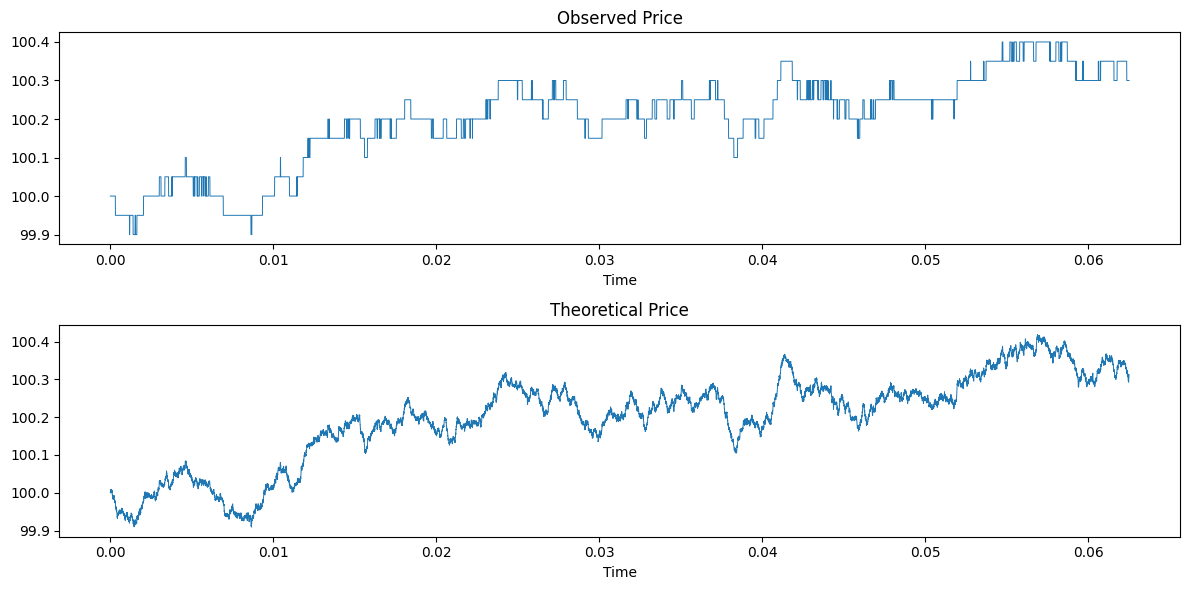

In [91]:
S_hft, S, ls, time_to_change = observed_price(mu, sigma, S0, dt, t, eta, alpha)

time_simulation = 10 * (3600//2)
fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=False)

axs[0].plot(t[:time_simulation], S_hft[:time_simulation], linewidth=0.7)
axs[0].set_title('Observed Price')
axs[0].set_xlabel('Time')

axs[1].plot(t[:time_simulation], S[:time_simulation], linewidth=0.7)
axs[1].set_title('Theoretical Price')
axs[1].set_xlabel('Time')

plt.tight_layout()
plt.show()

### Histogram plot of $L_{i}$

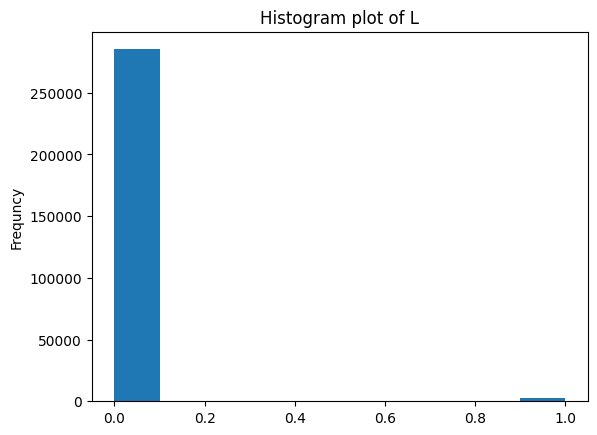

In [92]:
plt.hist(ls)
plt.title('Histogram plot of L')
plt.ylabel('Frequncy')
plt.show()

### Duration of change in price

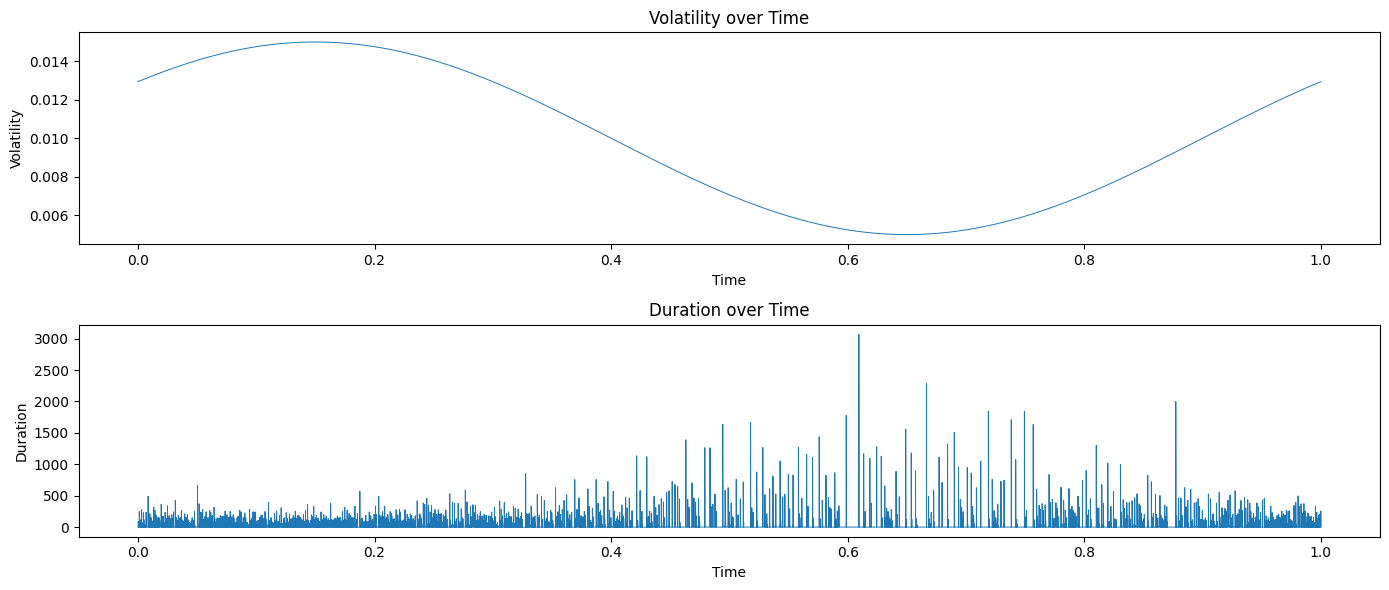

In [93]:
# Create a figure with two subplots stacked vertically
fig, axs = plt.subplots(2, 1, figsize=(14, 6), sharex=False)

# Plot the first subplot
axs[0].plot(t, sigma, linewidth=0.7)
axs[0].set_ylabel("Volatility")
axs[0].set_title('Volatility over Time')
axs[0].set_xlabel("Time")

# Plot the second subplot
axs[1].plot(t, time_to_change, linewidth=0.7)
axs[1].set_title('Duration over Time')
axs[1].set_ylabel("Duration")
axs[1].set_xlabel("Time")

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

### Integrated Volatility Estimator

**Here we study a volatility that is constant.**

In [37]:
sigma_bs = 0.03 * np.ones(sigma.size)

In [38]:
def get_prices(S_hft : np.array) -> np.array :
    """ This function returns the array of P_t_i"""
    
    prices = [S_hft[0]]
    for cur_price in S_hft :
        if cur_price != prices[-1] :
            prices.append(cur_price)
    
    return np.array(prices)
    

def get_X(prices: np.array, eta: float, alpha: float) -> np.array:
    
    Xs = prices[1 :] - np.sign(prices[1:] - prices[: -1]) * (.5 - eta) * alpha
    return Xs

def integrated_volatility_estimator(prices, eta, alpha):
    Xs = get_X(prices, eta, alpha)
    
    return np.sum(((Xs[1:] - Xs[:-1])/Xs[:-1])**2)

def second_integrated_volatility_estimator(prices, eta, alpha):
    Xs = get_X(prices, eta, alpha)
    
    return np.sum((np.log(Xs[1:]) - np.log(Xs[:-1]))**2)   

In [39]:
# Generating Monte Carlo study
M = 10
integrated_volatility_mc1 = np.zeros(M)
integrated_volatility_mc2 = np.zeros(M)

for i in range(M):
    S_hft, _, _, _ = observed_price(mu, sigma_bs, S0, dt, t, eta, alpha)
    prices = get_prices(S_hft)
    
    integrated_volatility_mc1[i] = integrated_volatility_estimator(prices, eta, alpha)
    integrated_volatility_mc2[i] = second_integrated_volatility_estimator(prices, eta, alpha)

In [1]:
# theoretical_integral = sigma_bs[0]**2

# plt.figure(figsize = (12,6))
# plt.hist(integrated_volatility_mc1, alpha = 0.7, label = 'Estimator', edgecolor='black')
# plt.title('Histogram plot of the integrated volatility estimator, using the real value of $\eta$')
# plt.ylabel('Frequency')
# plt.xlabel('Integrated Volatility')
# plt.axvline(theoretical_integral, color = 'red', label = 'Theoretical Value')
# plt.legend()
# plt.show()

# theoretical_integral = sigma_bs[0]**2

# plt.figure(figsize = (12,6))
# plt.hist(integrated_volatility_mc2, alpha = 0.7, label = 'Estimator', edgecolor='black')
# plt.title('Histogram plot of the seconf integrated volatility estimator, using the real value of eta')
# plt.ylabel('Frequency')
# plt.xlabel('Integrated Volatility')
# plt.axvline(theoretical_integral, color = 'black', label = 'Theoretical Value')
# plt.legend()
# plt.show()

In [2]:
# # Generating Monte Carlo study

# M = 100
# integrated_volatility_mc = np.zeros(M)

# for i in range(M):
#     S_hft, _, _, _ = observed_price(mu, sigma_bs, S0, dt, t, eta, alpha)
#     prices = get_prices(S_hft)
    
#     integrated_volatility_mc[i] = second_integrated_volatility_estimator(prices, eta, alpha)

In [3]:
# theoretical_integral = sigma_bs[0]**2

# plt.figure(figsize = (12,6))
# plt.hist(integrated_volatility_mc, alpha = 0.7, label = 'Estimator')
# plt.title('Histogram plot of the seconf integrated volatility estimator, using the real value of eta')
# plt.ylabel('Frequency')
# plt.xlabel('Integrated Volatility')
# plt.axvline(theoretical_integral, color = 'black', label = 'Theoretical Value')
# plt.legend()
# plt.show()

## Estimation of $eta$

To estimation eta, we assume that the jump sizes of two consucetive price is bounded, and we denote $m$ the maximum jump. (In practice, with a small volatility, jumps that exceed two are very rare)

We define $N^{(a)}_{\alpha, t, k}$ and $N^{(c)}_{\alpha, t, k}$  :

$$N^{(a)}_{\alpha, t, k} = \sum_{t_i \le t} \mathbb{I}_{ \{(P_{t_i} - P_{t_{i-1}})(P_{t_{i-1}} - P_{t_{i-2}}) < 0  \text{ and } |P_{t_i} - P_{t_{i-1}}| = k \alpha \}} $$

$$N^{(c)}_{\alpha, t, k} = \sum_{t_i \le t} \mathbb{I}_{ \{(P_{t_i} - P_{t_{i-1}})(P_{t_{i-1}} - P_{t_{i-2}}) > 0  \text{ and } |P_{t_i} - P_{t_{i-1}}| = k \alpha \}} $$

for $k = 1 ... m $.


We define the estimator of $\eta$ by : 

$$\hat{\eta}_{\alpha, t} = \min\left( \max\left(0, \sum_{k=1}^{m} \lambda_{\alpha, t, k}  u_{\alpha, t, k}\right) , 1\right) $$

where $$\lambda_{\alpha, t, k} = \frac{N^{(a)}_{\alpha, t, k} + N^{(c)}_{\alpha, t, k}}{ \sum_{j=1}^{m} (N^{(a)}_{\alpha, t, j} + N^{(c)}_{\alpha, t, j})}  \text{ and } u_{\alpha, t, k} = \frac{1}{2} \left( k \left( \frac{N^{(c)}_{\alpha, t, k}}{N^{(a)}_{\alpha, t, k}} - 1\right) + 1 \right)$$

In [41]:
def get_N_a(prices : np.array, alpha : float, m : int) -> np.array :
    N_a = np.zeros(m)
    for i in range(2, len(prices)) :
        if (prices[i]-prices[i-1]) * (prices[i-1]-prices[i-2]) < 0 :
            k = round(np.abs(prices[i]-prices[i-1]) / alpha)
            if (k > m) :
                print('error, the maximum jump has been exceeded')
            else :
                N_a[k-1] += 1
                
    return N_a

def get_N_c(prices : np.array, alpha : float, m : int) -> np.array :
    N_c = np.zeros(m)
    for i in range(2, len(prices)) :
        if (prices[i]-prices[i-1]) * (prices[i-1]-prices[i-2]) > 0 :
            k = round(np.abs(prices[i]-prices[i-1]) / alpha)
            if (k > m) :
                print('error, the maximum jump has been exceeded')
            else :
                N_c[k-1] += 1
                
    return N_c

def eta_estimator(prices : np.array, alpha : float, m : int) :
    
    N_a = get_N_a(prices, alpha, m)
    N_c = get_N_c(prices, alpha, m)
    
    sum = 0
    for k in range(1, m+1) :
        if (N_a[k-1] == 0) : continue
        lmd = (N_a[k-1] + N_c[k-1]) / (np.sum(N_a) + np.sum(N_c)) 
        u = 1/2 * (k * (N_c[k-1]/N_a[k-1]-1) + 1)
        sum += lmd * u
    estimation_eta = min(max(0, sum), 1)
    
    return estimation_eta

In [4]:
# # Estimaion of eta : Monte Carlo

# M = 100
# eta_estimations = np.zeros(M)
# m = 3  # Maximum tick jumps

# for i in range(M):
#     S_hft, S, ls, time_to_change = observed_price(mu, sigma_bs, S0, dt, t, eta, alpha)
#     prices = get_prices(S_hft)
#     eta_estimations[i] = eta_estimator(prices, alpha, m)

In [5]:
# print(f"Mean ETA Estimation: {eta_estimations.mean()}")
# print(f"Original ETA values: {eta}")

# plt.hist(eta_estimations, bins=30, color='skyblue', edgecolor='black')
# plt.xlabel('ETA Estimations')
# plt.ylabel('Frequency')
# plt.title('Distribution of ETA Estimations')


**Estimator of the integrated volatility with the estimated eta**

In [30]:
def integrated_vol_estimator(X : np.array) -> np.array :
    estimations = np.zeros(X.shape[0])
    for i in range(len(estimations)) :
        prices = get_prices(X[i, :])
        estimated_eta = eta_estimator(prices, alpha, m = 3)
        estimations[i] = integrated_volatility_estimator(prices, estimated_eta, alpha)
    return estimations

In [31]:
from tqdm import tqdm

In [95]:
# Generating Monte Carlo study
M = 1000
integrated_volatility_mc = np.zeros(M)

for i in tqdm(range(M)):
    S_hft, _, _, _ = observed_price(mu, sigma_bs, S0, dt, t, eta, alpha)
    prices = get_prices(S_hft)
    estimated_eta = eta_estimator(prices, alpha, m = 3)
    integrated_volatility_mc[i] = integrated_volatility_estimator(prices, estimated_eta, alpha)

100%|██████████| 1000/1000 [05:04<00:00,  3.28it/s]


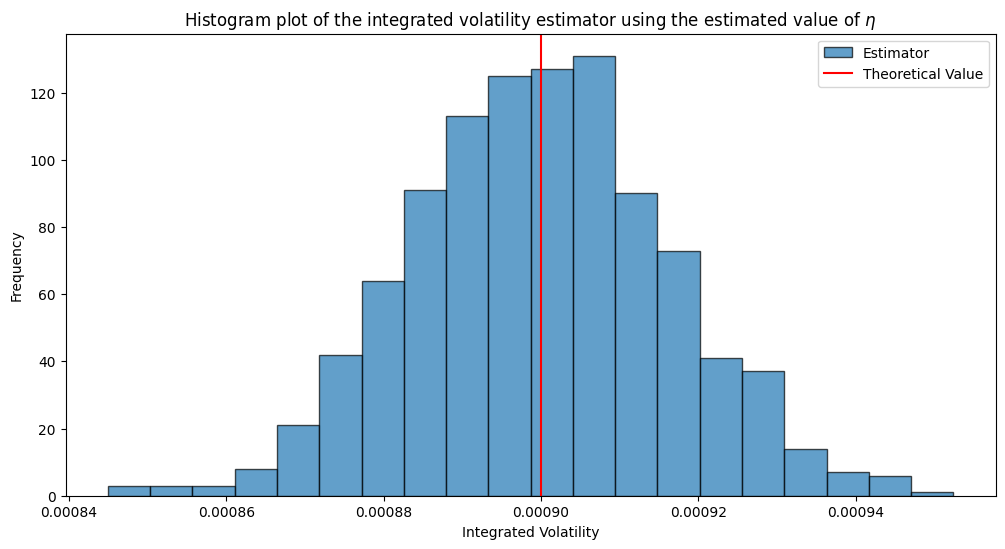

In [96]:
theoretical_integral = sigma_bs[0]**2

plt.figure(figsize = (12,6))
plt.hist(integrated_volatility_mc, alpha = 0.7, label = 'Estimator', edgecolor='black', bins = 20)
plt.title('Histogram plot of the integrated volatility estimator using the estimated value of $\eta$')
plt.ylabel('Frequency')
plt.xlabel('Integrated Volatility')
plt.axvline(theoretical_integral, color = 'red', label = 'Theoretical Value')
plt.legend()
plt.show()

## Comparing Volatility Estimators

In this section we will compare the volatility estimators of the Integrated Volatility notebook against the one proposed in this notebook. The main idea being that now the price of the asset reflects more precisely the discretization effects present in real market. It is, for example, discretized by the tick size, something that was not present in the Integrated Volatility paper that we studied.

Here we will assume that the volatility is constant. We are therefore under the Black-Scholes model.

In [97]:
estimated_vol4 = np.zeros(100)

def get_vol4() :
    print(estimated_vol4.mean())
    return estimated_vol4

In [103]:
def IQ(Y : np.array):
    step = 5 * 60 * 10# each five minutes
    n_sparse = mesh // step
    dY_4 = np.diff(Y[:, ::step])**4.0
    return n_sparse * 1/3 * dY_4.sum(axis=1)

def fifth_best_estimator(Y: np.array) -> float:
    ''' Implements the fifth best estimator. It simply compute the sum
    of the squares of the log returns.
    '''
    dY = np.diff(Y, axis = 1)
    return np.square(dY).sum(axis = 1)

def get_e2(Y: np.array) -> np.array:
    ''' Returns an estimation of E[eps^2]
    '''
    noise2 = (1/(2*mesh)) * fifth_best_estimator(Y)
    return noise2.mean()

def fourth_best_estimator(Y: np.array, n_sparse: int) -> float:
    ''' Same as fifth but samples sparsely on the log returns
    '''
    dY = np.diff(Y, axis = 1)
    try:
        step = mesh // n_sparse
    except ZeroDivisionError as e:
        step = 1
    print(step)
    return np.square(dY[:,::step]).sum(axis = 1)


def third_best_estimator(Y: np.array, vol4 : float = get_vol4()) -> float:
    ''' Applies the fourth best estimator using the best step
    Estimation of noise is discussed in page 5 of the paper.
    '''
    e2 = get_e2(Y)

    n_sparse_optimal = ((T/4)*(vol4/e2**2))**(1/3)
    print(n_sparse_optimal.mean())
    return fourth_best_estimator(Y, int(n_sparse_optimal.mean()))


def second_best_estimator(Y: np.array, optimal : bool, K: np.array = np.NAN, vol4 : float = get_vol4()) -> np.array:
    ''' Split the data in K grids, with each one being composed of 
    i, i+K, i+2K, ... i going from 1 to K.
    If no value of K is passed the optimal value is computed.
    '''
    if optimal :
        e2 = get_e2(Y)
        n_star = (T*vol4/(6*e2**2))**(1/3)
        K = mesh / n_star
           
    estimator = np.zeros(Y.shape[0])
    for j in range(Y.shape[0]) :
        k = int(K[j])
        k = max(k,1)
        for i in range(k):
            estimator[j] += np.square(np.diff(Y[j, i::k])).sum()
        estimator[j] /= k
        
    return estimator

def first_best_estimator(Y: np.array, vol4 : float = get_vol4()) -> float:
    '''Implements best estimator proposed by the paper
        
    '''
    e2 = get_e2(Y)
    
    c_star = ((T/12) * vol4 / e2**2)**(-1/3)
    K_star = c_star * mesh**(2/3)
    
    n_bar =  (mesh - K_star + 1) / K_star 
    print(n_bar)
    return (1 - (n_bar / mesh)) * (second_best_estimator(Y, False, K_star) - (n_bar / mesh) * fifth_best_estimator(Y))

8.145382038555524e-07
8.145382038555524e-07
8.145382038555524e-07


In [100]:
# M = 100

# # Simulation of M observed price of a black scholes prices, with mu = 0
# X = np.zeros((M, mesh))
# for i in tqdm(range(M)) :
#     X[i, :], _, _, _ = observed_price(mu, sigma_bs, S0, dt, t, eta, alpha)

In [105]:
# M = 1000

# # Simulation of M observed price of a black scholes prices, with mu = 0
# X = np.zeros((M, mesh))
# for i in tqdm(range(M)) :
#     X[i, :], _, _, _ = observed_price(mu, sigma_bs, S0, dt, t, eta, alpha)

In [106]:
# Compute the log returns
Y = np.log(X)
estimated_vol4 = IQ(Y)

third_vol_estimator_bs_IQ = third_best_estimator(Y)
second_vol_estimator_bs_IQ = second_best_estimator(Y, True, K=np.NAN)
first_vol_estimator_bs_IQ = first_best_estimator(Y)
# new_estimator_bs = integrated_vol_estimator(X)

1620.2881895033308
177
[ 65496.57410087  83926.45481406  78111.2715791   59231.09624756
  81467.97860444  78338.89642991  73475.21773157  69315.2527844
  76039.81460847  73110.77363689  65192.37103938  74759.19858512
  89746.7812017   77514.90773298  58385.36059725  76579.73244335
  70476.22778789  67751.7632846   85152.66223035  69784.50059539
  65036.51138776  69885.23331727  69655.79328799  74669.65398805
  70762.59984588  64053.38881461 102791.58428649  72356.97281413
  72004.62158947  71865.33203011  64907.27996692  75943.65152348
  71564.46979501  85814.22337205  74539.42459762  81904.19952157
  70213.68982009  74970.16206556  60670.91978236  58047.94937593
  81142.51070907  80214.43606951  86898.41456227  75004.95427485
  71466.13849802  71391.24981247  78965.3009747   67587.80310282
  59414.19434198  76714.24052325  78223.17439928  76941.32634058
  79099.67912977  67303.69095663  65728.6401848   76269.49976104
  71234.36408554  70634.83493679  80336.96887733  88328.85562838
  6

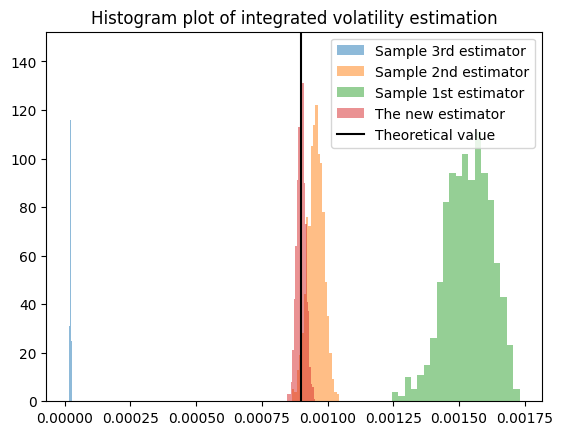

In [107]:
Labels = ['Sample 3rd estimator','Sample 2nd estimator','Sample 1st estimator', 'The new estimator']
estimators = [third_vol_estimator_bs_IQ, second_vol_estimator_bs_IQ, first_vol_estimator_bs_IQ, integrated_volatility_mc]

for k in range(4) :
    plt.hist(estimators[k], bins = 20, label = Labels[k], alpha = 0.5)
plt.axvline(theoretical_integral, label = 'Theoretical value', color = 'black')
plt.title("Histogram plot of integrated volatility estimation")
plt.legend()
plt.show()

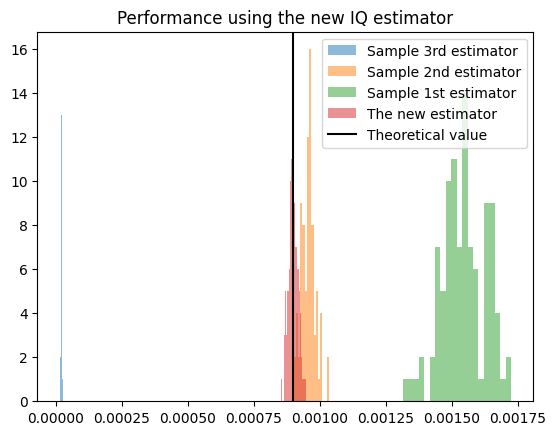

In [94]:
Labels = ['Sample 3rd estimator','Sample 2nd estimator','Sample 1st estimator', 'The new estimator']
estimators = [third_vol_estimator_bs_IQ, second_vol_estimator_bs_IQ, first_vol_estimator_bs_IQ, integrated_volatility_mc]

for k in range(4) :
    plt.hist(estimators[k], bins = 20, label = Labels[k], alpha = 0.5)
plt.axvline(theoretical_integral, label = 'Theoretical value', color = 'black')
plt.title("Performance using the new IQ estimator")
plt.legend()
plt.show()

In [6]:
# M = 100

# # Simulation of M observed price of a black scholes prices, with mu = 0
# # X = np.zeros((M, mesh))
# # for i in range(M) :
# #     X[i, :], _, _, _ = observed_price(mu, sigma_bs, S0, dt, t, eta, alpha)

# # Compute the log returns
# Y = np.log(X)
# estimated_vol4 = sigma_bs[0]**4

# third_vol_estimator_bs_IQ = third_best_estimator(Y)
# second_vol_estimator_bs_IQ = second_best_estimator(Y, True, K=np.NAN)
# first_vol_estimator_bs_IQ = first_best_estimator(Y)
# # new_estimator_bs = integrated_vol_estimator(X)


# Labels = ['Sample 3rd estimator','Sample 2nd estimator','Sample 1st estimator', 'The new estimator']
# estimators = [third_vol_estimator_bs_IQ, second_vol_estimator_bs_IQ, first_vol_estimator_bs_IQ, integrated_volatility_mc]

# for k in range(4) :
#     plt.hist(estimators[k], bins = 20, label = Labels[k], alpha = 0.5)
# plt.axvline(theoretical_integral, label = 'Theoretical value', color = 'black')
# plt.title("Performance using the new IQ estimator")
# plt.legend()
# plt.show()